# Assignment 1 - Part 2

<div class="alert alert-block alert-warning">
    Below we import <a href="https://github.com/HIPS/autograd">autograd</a>. If you get an error saying you don't have it, you will need to install it with pip, using
<pre>
pip install autograd
</pre>
</div>

In [210]:
import  autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian, grad

## Newton's Method

We want to approximate solutions of nonlinear equation in __two variables__ using Newton's method.

Newton's method is implemented below.

Implement a stopping criterion. That is, given some tolerance $TOL$, end the method when $\mathbf{x}^k:=(x_1^k,x_2^k)$ satisfies $\|F(\mathbf{x}^k)\|_2\le TOL$ or $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2\le TOL$.

Provide numerical evidence that your code works as it should by printing the values of $\|F(\mathbf{x}^k)\|_2$ for each iteration, and by making a plot of $\|F(\mathbf{x}^k)\|_2$, $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2$, for all $k$.

Now, verify numerically the convergence is quadratic. You will need a reference solution, and one can do this in two ways:

 - Consider a problem for which you know an exact solution, and use said solution as a reference solution,
 - or for your problem, should you not know a solution, use the method to obtain an extremely accurate result which you use as a reference solution

In [211]:
def newtonsMethod(F, x0, maxIter=50, TOL=1.0e-20):
    # Implementation of Newton's root finding method.
    # F - the function you wish to find the root for,
    # x0 - initial guess,
    # maxIter - maximum number of iterations.
    DF = jacobian(F)
    x1 = x0

    A = []
    I = []
    D = []
    S = []
    
    for k in range(0, maxIter):
        x0 = x1
        J = DF(x0)
        Fx = F(x0)
        x1 = x0 - np.linalg.solve(J,Fx)
        A.append(k)
        I.append(np.linalg.norm(Fx,2))
        D.append(np.linalg.norm(x1-x0,2))
        if (np.linalg.norm((x1-x0),2)<=TOL) or (np.linalg.norm(x1,2)<=TOL): break

    #Hvordan genere sekvens for å vise at den er kvadratisk konvergent?????????
    for i in range(len(I)-2):
        S.append(np.log(np.linalg.norm(I[i]-I[i+1])/np.log(np.linalg.norm(I[i+1]-I[i+2]))))

    print()
    print(f"RateOfConvergence:\n{S}")

    plt.figure()
    plt.plot(A, I)
    plt.plot(A, D)

    return x1


RateOfConvergence:
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Zero:
[8.8817842e-16 0.0000000e+00]
/home/shomec/t/thomawt/.local/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


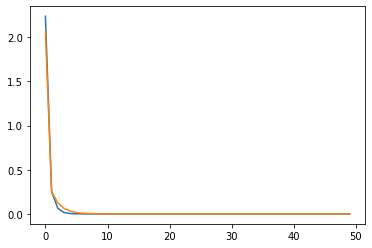

In [212]:
f = lambda v: np.array([v[0]**2,v[1]])
print(f"Zero:\n{newtonsMethod(f, np.array([1.,2.]))}")


RateOfConvergence:
[]
Zero:
[-2.  1.]


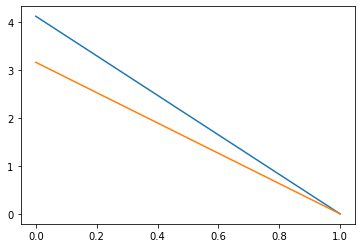

In [213]:
g = lambda v: np.array([v[1]+v[0]+1,v[1]-1])
print(f"Zero:\n{newtonsMethod(g,np.array([1.,2.]))}")

## Linear systems

Consider the linear system 
	\begin{equation*}
	A \mathbf{u} = \mathbf{f},
	\end{equation*}
where $A$ is a finite-difference discretization of the 2D Laplacian, this is a block tridiagonal matrix, implemented in the code below, and $\mathbf{f}$ is the vector with all components equal to one.

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy import linalg

# Creating the 2D laplacian matrix
def create2DLaplacian(nx, ny):
    N  = nx*ny
    main_diag = np.ones(N)*-4.0
    side_diag = np.ones(N-1)
    side_diag[np.arange(1,N)%4==0] = 0
    up_down_diag = np.ones(N-3)
    diagonals = [main_diag,side_diag,side_diag,up_down_diag,up_down_diag]
    laplacian = sparse.diags(diagonals, [0, -1, 1,nx,-nx])
    return laplacian*np.eye(N)

test = create2DLaplacian(3,3)
print(test)

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  1. -4.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  1.  0.  1.]
 [ 0.  0.  0.  1.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0. -4.]]


We will now approximate the solution of this linear system using some different iteration methods of the type 
	\begin{equation*}
		A_1 \mathbf{u}^{(k+1)} = A_2 \mathbf{u}^{(k)}+\mathbf{f},
	\end{equation*}
	where $A = A_1 - A_2$ with $|A_1|\ne0$. The way we choose the matrices $A_1$ and $A_2$ depends upon the method. We will use the following iterative methods to calculate approximate solutions to $\mathbf{u}$:

a) Jacobi ($A_1 = A_d$).

b) Forward Gauss-Seidel ($A_1 = A_d-A_l$).

c) Successive over relaxation ($A_1 = A_d-\omega A_l$, where you can choose the value of $\omega\in (0,1)$).

Here $A = A_d - A_l - A_u$, where

- $A_d$ is the diagonal of $A$,
- $A_l$ is $-$(strictly lower triangular part of $A$),
- $A_u$ is $-$(strictly upper triangular part of $A$).

Consider the residual vector $\mathbf{r}^k:=\mathbf{f}-A\mathbf{u}^k$. We fix $nx=ny=10$ and $N=100$. For each of the above, you should:

i) Compare the convergence of each method. Submit  a semi-log plot of the $2$-norm of the relative residual $\frac{ \|\mathbf{r}^k\|_2 }{ \| \mathbf{r}^0\|_2 }$ versus the number of iterations. Plot all the methods in the same plot for comparison.
Experiment choosing different values of $\omega$ in the SOR method, try to find a value that gives you optimal convergence for this problem.


ii) Implement a stopping criterion for the three methods as you have done for the Newton method. Record the relative time each method takes per iteration, and the rime needed to obtain a norm of the relative residual below toleances  $TOL=1e-7$ and $TOL=1e-14$. Make a table with the results for each method.

In [215]:
toRun = create2DLaplacian(10,10)
print(toRun)

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]


In [216]:
def extractDiagonal(A):
    return np.diag(np.diag(A))

def extractLower(A):
    return -1*sparse.tril(A,-1)*np.eye(N)

def extractUpper(A):
    return -1*sparse.triu(A,1)*np.eye(N)

In [217]:
def generalIteration(A, B, C, f, u0, maxIter, TOL):
    u1 = u0

    Iter = [u0]

    for i in range(maxIter):
        u0 = u1
        u1 = B @ (C @ u0 + f)
        Iter.append(u1)
        if (np.linalg.norm(A@u1-f) <= TOL) or (np.linalg.norm(u1-u0) <= TOL) : break

    return Iter

In [218]:
def jacobiMeth(A, f, u0, maxIter = 50, TOL = 1e-10, *args):
    inv = lambda x: 1/x 
    A1Inv = np.diag(inv(np.diag(A)))
    A2 = extractDiagonal(A) - A

    return generalIteration(A, A1Inv, A2, f, u0, maxIter, TOL)

In [219]:
def ForwardGSMeth(A, f, u0, maxIter = 50, TOL = 1e-10, *args):
    A1Inv = np.linalg.inv(extractDiagonal(A) - extractLower(A))
    A2 = extractUpper(A)

    return generalIteration(A, A1Inv, A2, f, u0, maxIter, TOL)

In [220]:
def SuccessOverRelaxMeth(A, f, u0, maxIter = 50, TOL = 1e-10, *args):
    if len(list(args)) == 0:
        w = 0.5
    else:
        w = args[0]
    print(w)
    A1Inv = np.linalg.inv(extractDiagonal(A) - w*extractLower(A))
    A2 = (1-w)*extractLower(A) + extractUpper(A)

    return generalIteration(A, A1Inv, A2, f, u0, maxIter, TOL)

In [221]:
np.random.seed()

def testIteration(Iterative, A = test, f = np.random.rand(9), u0 = np.random.rand(9), maxIter = 50, TOL = 1e-10, *args):
    out = Iterative(A, f, u0, maxIter, TOL, *args)

    print(f"u0:\n{u0}")
    print(f"f:\n{f}")
    print(f"Solution:\n{out[-1]}")

    out.insert(0,np.random.rand(9))
    res = [np.linalg.norm(x)/np.linalg.norm(u0) for x in out]
    plt.semilogx(res)

u0:
[0.07562212 0.97106434 0.71519887 0.855501   0.15621208 0.87459938
 0.48052234 0.10015388 0.50934264]
f:
[0.22253422 0.19152088 0.94829217 0.80555994 0.16054963 0.29713915
 0.15167007 0.532724   0.11752464]
Solution:
[-0.25561773 -0.31839245 -0.53586306 -0.48154423 -0.29056814 -0.39522339
 -0.32913619 -0.28810708 -0.12818701]


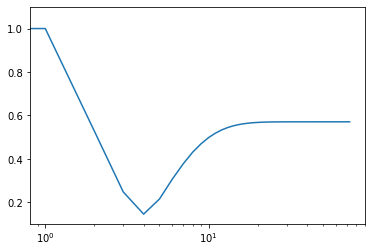

In [222]:
testIteration(jacobiMeth, maxIter = 1000)

u0:
[0.07562212 0.97106434 0.71519887 0.855501   0.15621208 0.87459938
 0.48052234 0.10015388 0.50934264]
f:
[0.22253422 0.19152088 0.94829217 0.80555994 0.16054963 0.29713915
 0.15167007 0.532724   0.11752464]
Solution:
[-0.25561773 -0.31839245 -0.53586306 -0.48154423 -0.29056814 -0.39522339
 -0.32913619 -0.28810708 -0.12818701]


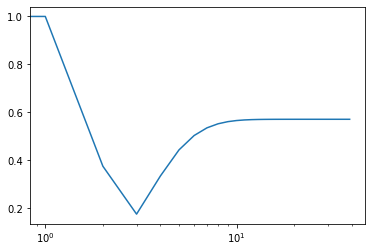

In [223]:
testIteration(ForwardGSMeth, maxIter = 1000)

0.1
u0:
[0.40630969 0.99819791 0.45157779 0.01983823 0.81313626 0.3729852
 0.34616077 0.67639979 0.54500835]
f:
[0.05260851 0.14728537 0.60973976 0.31048785 0.56962789 0.74487519
 0.0853923  0.44355541 0.64720505]
Solution:
[-0.16390823 -0.29589307 -0.44256563 -0.30713136 -0.42981309 -0.55749837
 -0.31156376 -0.29623306 -0.30117585]


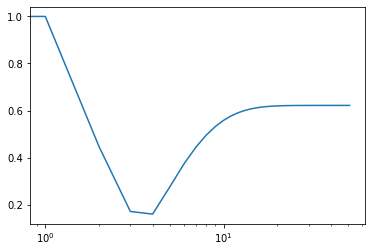

In [224]:
testIteration(SuccessOverRelaxMeth, test, np.random.rand(9), np.random.rand(9), 50, 1e-10, 0.1)

iii) Calculate the spectral radius of $A_1^{-1}A_2$ and see how that relates to convergence of the method. Make a semi-log plot for comparison. 

<div class="alert alert-block alert-info">
<b>Hint:</b> Python's 
    <pre>numpy.linalg.eigvals(A)</pre>
function returns the eigenvalues of $A$.
</div>